<h1><center>Breast Cancer Prediction w/ Machine Learning</center></h1>

**Background**: This notebook provides all the code you need to perform exploratory data analysis (EDA), manipulate the dataset for training, train a Random Forest Classifier ML model, generate predictions using your trained model, and write model performance back into an Azure SQL Database.

**Purpose**: Help those new(er) to machine learning understand how to prepare and train a model using a single example, and how to interact with a database using Python. 

**Project Outcome**: Trained ML model to predict whether a patient's breast mass is benign or malignant. 

**About The Data**: The data you will use is tabular (multivariate), containing diagnostic measurements relating to patients who underwent testing of a breast tissue mass. Below is a high-level collection process:

1. This process made use of what is called a fine needle aspiration (FNA), which uses a needle to remove cells from the lump/bump in question. 
2. The resulting fluid/cells are then placed on a slide under a FNA microscope, which records a fine image
3. The microscope saves a digitized image of the cells, which can contain measurements of certain figures.
4. The measurements of these figures in the image are recorded. 

The process above is what is followed to generate the data we are using. However, our dataset includes the 

**Process**: Through this notebook you'll be exposed to the following:
- Reading an Azure ML Dataset into a Pandas DataFrame
- Exploring the dataset to identify data types, null values, summary statistics, outliers, and more. 
- Detecting and removing outliers for the various features (measurements)
- Recognizing an imbalance in the dataset classes
- Using a data method called Stratified Kfold to prepare the imbalanced data for training
- Training a Random Forest Classifier
- Using the trained model to generate predictions on unseen data
- Writing the model performance into an Azure SQL Database table

**ML Problem Type**: Supervised, Classification

**Target Classes**: M = Malignant, B = Benign

**Data Flow**: Azure SQL Database -> Azure ML Dataset -> Azure ML Notebook (this) -> Azure SQL Database


## Import Libraries & Dataset

To get started, we'll import some Python packages that we'll need later on. Typically, in a notebook-style setting, you'll find the package imports to be within the cells they are needed. I've consolidated them into the first cell for simplicity. 

In [1]:
import pandas as pd 
# Used for data review/manipulation 

import numpy as np 
# Numerical library for mathematical operations/array manipulation   

import pyodbc 
# Used to connect to Azure SQL and run SQL commands 

import shap 
# For finding feature importance for our trained model

import matplotlib.pyplot as plt
# Used for graphical plotting (such as histograms)

from azureml.core import Workspace, Dataset
# Primary library for interacting with Azure ML workspace

from sklearn.model_selection import StratifiedKFold
# Scikit-Learn package for performing stratified kfold  

from sklearn.ensemble import RandomForestClassifier
# The actual Random Forest Classifier algorithm for training

from sklearn import metrics
# Package to grab metrics from our trained model, like accuracy

pd.set_option('display.max_columns', None) # removes Pandas column truncating
pd.set_option('display.max_rows', None) # removes Pandas row truncating

In [2]:
# Load in the dataset. This snippet generated/copied from the Azure ML portal.

subscription_id = '11443b27-222d-4035-8937-9ca228413757'
resource_group = 'rg-c1-bprescott-lab-02'
workspace_name = 'c1mxaml'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='breastcancer_dataset') # gets the dataset name from Azure ML
 
# Convert dataset to Pandas DataFrame
bcdf = dataset.to_pandas_dataframe() # converts the dataset object into a Pandas DataFrame

## Exploratory Analysis

Now that we have our dataset in a usable format (dataframe), lets start digging in.

The first thing to do is just preview our data, visually. This way we can get an idea for the size and type of data we're going to be working with. 

### Data Preview 

In [3]:
# View the first 5 records of our data
bcdf.head()

,id,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,diagnosis
0,842302,17.990000,10.380000,122.800003,1001.000000,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.399994,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.379999,17.330000,184.600006,2019.000000,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,842517,20.570000,17.770000,132.899994,1326.000000,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.080002,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990000,23.410000,158.800003,1956.000000,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,84300903,19.690001,21.250000,130.000000,1203.000000,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.029999,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570000,25.530001,152.500000,1709.000000,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,84348301,11.420000,20.379999,77.580002,386.100006,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.230000,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910000,26.500000,98.870003,567.700012,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,84358402,20.290001,14.340000,135.100006,1297.000000,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.440002,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540001,16.670000,152.199997,1575.000000,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


Now we can move into checking the actual data types of each column and how many null values each column has. Pandas has a simple method called .info() that will do this for us.

We can see that we have 569 entries (rows) across 32 columns. Of those 32 columns 30 of them are float/decimal data types, 1 is an integer column, and 1 is an object (string). We can also see that we have no null/missing entries in any of these columns.

We can also infer that the ID column is either the patient ID, or a unique identifier generated from the database. Either way, it is not a measurement and not something we'll use in training. (more on this later)

Additionally, we can see our only non-numeric column ('diagnosis') is our target variable, or what we are going to try to predict.

### Data Types & Null Count

In [4]:
# Using info() we can see we have no null values and only one non-numeric column, which is our target variable
bcdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  569 non-null    int64  
 1   radius1             569 non-null    float64
 2   texture1            569 non-null    float64
 3   perimeter1          569 non-null    float64
 4   area1               569 non-null    float64
 5   smoothness1         569 non-null    float64
 6   compactness1        569 non-null    float64
 7   concavity1          569 non-null    float64
 8   concave_points1     569 non-null    float64
 9   symmetry1           569 non-null    float64
 10  fractal_dimension1  569 non-null    float64
 11  radius2             569 non-null    float64
 12  texture2            569 non-null    float64
 13  perimeter2          569 non-null    float64
 14  area2               569 non-null    float64
 15  smoothness2         569 non-null    float64
 16  compactn

Another method we have is to run a Pandas method called .describe(). All this does is generate summary statistics for any numeric fields. Here we can see how many entries we have in each, the average (mean) value, standard deviation, etc. etc..

.describe() is often used as a means of initial sanity checking. 
- Are the ranges for the values what I'd expect to see? 
- Does the min/max make sense?
- How dispersed is our data?

### Summary Statistics

In [5]:
# Review summary stats of numeric columns
bcdf.describe()

,id,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583129,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491005,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356992,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790001,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.199997,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.169998,420.299988,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110001,515.299988,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.239998,551.099976,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530001,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660004,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.799999,104.099998,782.700012,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.189999,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790001,29.719999,125.400002,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110001,39.279999,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200012,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040001,49.540001,251.199997,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### Visualize Data Distributions

We can also generate some plots of each column's frequency distribution. This lets us see how distributed the values for each column are, possibly see if we might have some outliers, and also see if we have any skewed data. 

Based on the results we can see we have many features (columns) that are right (positively) skewed. This means that the majority of the data points have smaller values. We have a few (like 'smoothness3') that are normally distributed, meaning that the majority of the data points fall close to the mean or average value. 

You might ask: **why does this matter?**

Knowing the data distribution helps in determining if new values fall outside of the normal distribution for our training data. This is commonly referred to as out-of-distribution (OOD) data. If we have a new patient's measurement come in after we train our model, and it is OOD, we might want to not predict the result as it falls outside of the expected distribution.

In that same light, the "skewness", or distribution skew, also helps tell us the direction of the data's outliers. For those positively skewed (right skew), the outliers will occur both further towards the right, and closer to the mean of the values (on the left). 


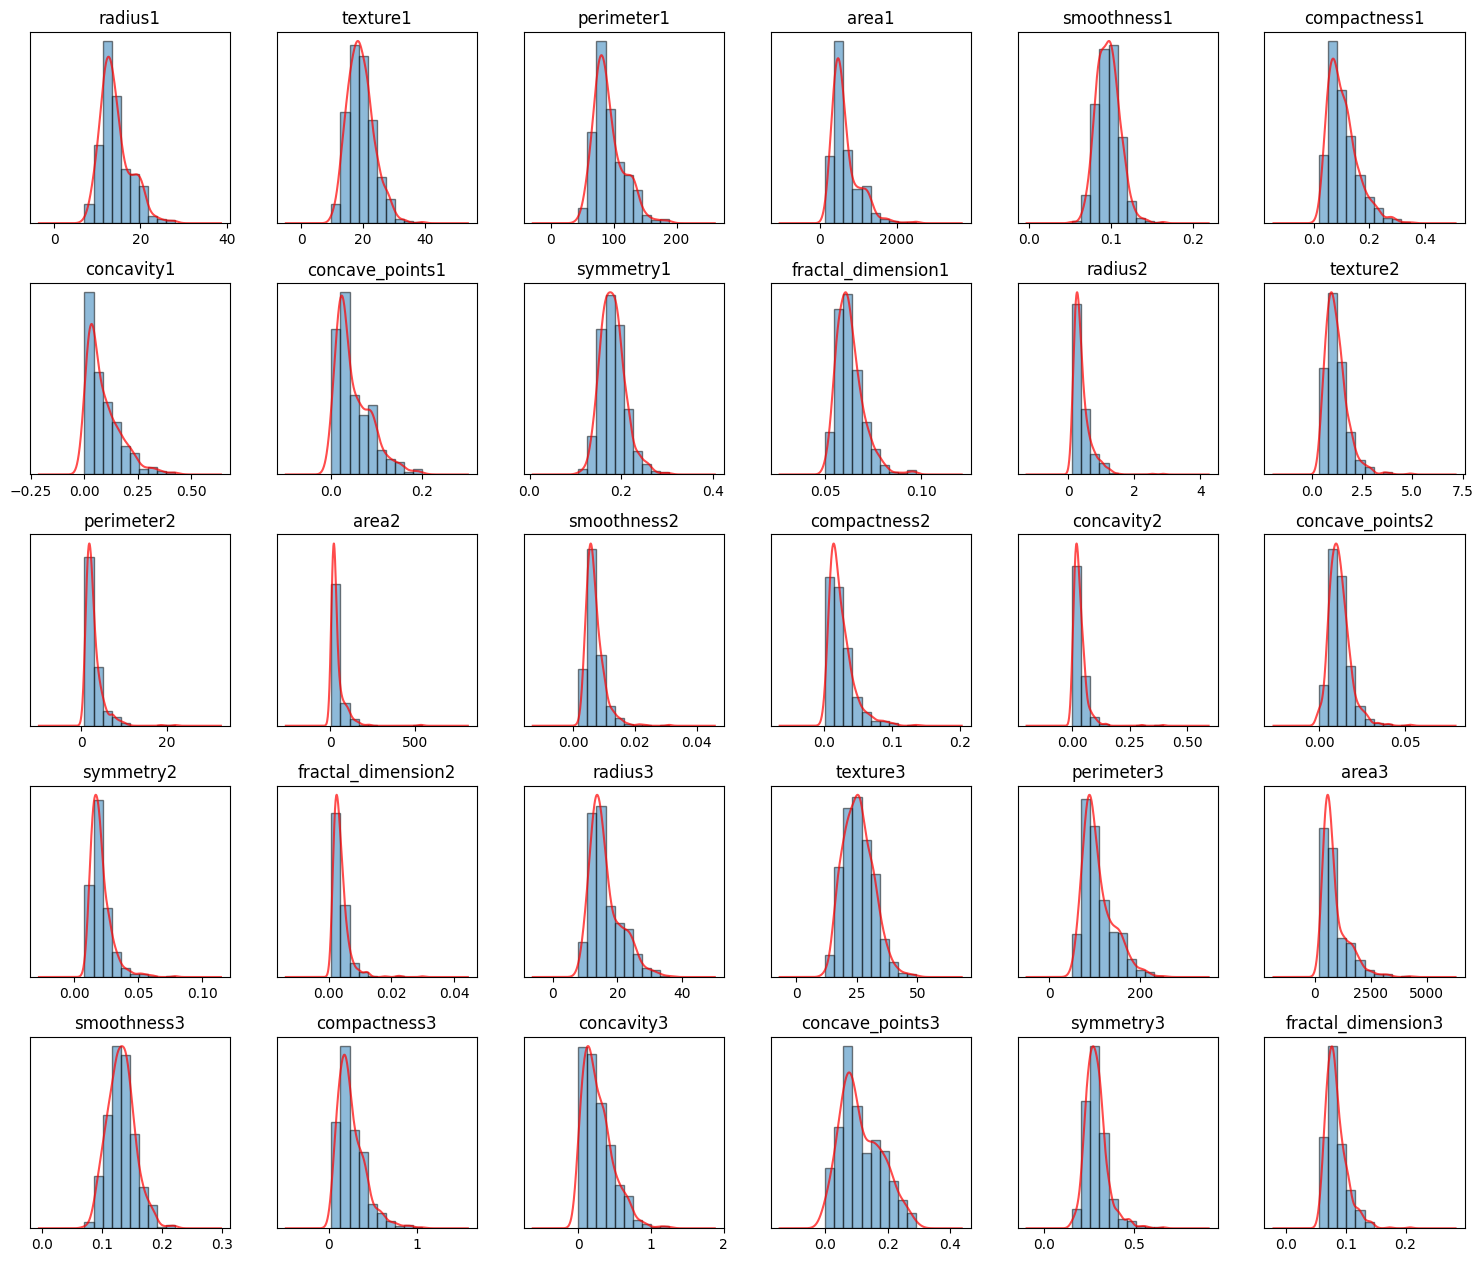

In [77]:
# set overall size of the resulting figure
plt.figure(figsize=(15,15))

# which index (plot location) to start at
n = 1

# iterate over every column in the dataframe...
for c in bcdf.iloc[:,1:].columns: 
    # use only columns that are a numeric type...
    if bcdf[c].dtype != 'O': 
        # leverage a subplot layout of UP TO 6x6
        plt.subplot(6, 6, n)
        # use a tight spacing layout (saves space)
        plt.tight_layout(h_pad=1)
        # create a histogram for the column
        plt.hist(bcdf[c],density = True, alpha=.5, histtype='bar', ec='black')
        # overlay the "bell curve" 
        bcdf[c].plot(kind='kde',color='red',alpha=0.7)
        # remove the y axis markers (keeps it clean)
        plt.yticks([])
        # remove the y axis label (keeps it clean)
        plt.ylabel('')
        # set the title of each subplot as the column name
        plt.title(c)
        # increment the index by 1 (move to next subplot position) 
        n += 1

### Check For Duplication & Class Counts 

While we checked for null values earlier, we don't know if we have any duplicate rows. If we treat our 'ID' column as a patient's ID, we could argue that we might have more than one row pertaining to the same patient ID (maybe a patient had two FNAs done). 

In that scenario, we would rather check if we have completely duplicated columns across all features. This would mean someone might have accidentally entered the same information twice.

To do that, we can (again) use a Pandas method called .duplicated(), which will look for any rows that are completely identical. 

W'll also use the .value_counts() method to get a count of how many benign and malignant samples we have.

In [24]:
# Review duplicates and important counts

print("""
Number of duplicate rows: {}
Number of duplicate patient IDs: {}
Benign samples = {}
Malignant samples = {}"""
      .format(sum(bcdf.duplicated()),
              sum(bcdf['id'].duplicated()),
              bcdf['diagnosis'].value_counts()[0],
              bcdf['diagnosis'].value_counts()[1]))


Number of duplicate rows: 0
Number of duplicate patient IDs: 0
Benign samples = 357
Malignant samples = 212


<h1 style="color:red;"><center>!!! IMPORTANT !!!</center></h1>

Looking at the results above, we can see we don't have any duplicates, which is great. However, we can see we have more benign samples than malignant samples. 

This usually opens the question of "will I be training my model with biased/skewed data?".

Typically in classification problems (like this one), you want to have as balanced of a dataset as possible so that the model doesn't learn against a skewed dataset. Below are some methods that could help this situation:

**Cut down the number of benign samples to match malignant**
 - Pros: easy to do, fast
 - Cons: causes loss of valuable training data

**Find additional datasets to increase the malignant samples**
 - Pros: would help expand the dataset naturally
 - Cons: might not exist, difficult to find new/exact data, potentially slow process

**Use various data samples techniques that help with imbalanced data**
 - Pros: typically easy to implement, can be part of your preprocessing steps
 - Cons: requires knowledge of how they work, could be slow depending on dataset size

**Generate synthetic data to augment the malignant samples**
 - Pros: helps to expand datasets synthetically, doesn't require new/additional datasets
 - Cons: generated data might not be realistic, requires training models to generate data first

For the sake of this tutorial, we'll use a data sampling technique called Stratified Kfold (discussed later).

## Outlier Detection / Removal

Another point of interest that is often overlooked is that of outliers and/or *extreme* outliers. 

Simply put, an outlier is a data point that falls outside of the normal distribution. For example, if one of my measurement fields is between a minimum of 2 and maximum of 40, then a data point with a value of 1 is considered an outlier. The same is true for anything over 40. 

Using that same example, if we see a data point with value 1400 on a scale of 2 to 40, we would consider that an *extreme* outlier, as it is drastically outside of the normal distribution. 

The reason we care about outliers is that they can throw off our training process. When the algorithm is trying to optimize a function that represents the data points, that function might be changed drastically when it encounters these unusual data points. We want to keep things are "normal" as possible. 

Those slightly outside of the distribution are less impactful than extreme outliers, but we really *should* care about all of them. 

In [25]:
multiplier = 1.5 # multiplier for finding normal outliers. 3 for extreme.

boundaries = {} # empty dictionary to add column names and lower/upper bounds to

# iterate over dataframe columns and identify outlier range for each column
for col in bcdf.iloc[:,1:-1].columns:
    if bcdf[col].dtype != 'O':
        firstq = np.percentile(bcdf[col], 25)
        thirdq = np.percentile(bcdf[col], 75)
        iqr = thirdq - firstq
        lb = firstq - (multiplier * iqr)
        ub = thirdq + (multiplier * iqr)
        boundaries[col] = [lb,ub]
        
# add outlier information to dictionary
for key in boundaries:
    bcdf2 = bcdf[bcdf[key] > boundaries[key][0]]
    bcdf2 = bcdf[bcdf[key] < boundaries[key][1]]
    
# reset the index count on the new dataframe
bcdf2.reset_index(drop=True,inplace=True)

print("Old dataframe target counts: Benign = {}, Malignant = {}".format(bcdf['diagnosis'].value_counts()[0],bcdf['diagnosis'].value_counts()[1]))
print("NEW dataframe target counts: Benign = {}, Malignant = {}".format(bcdf2['diagnosis'].value_counts()[0],bcdf2['diagnosis'].value_counts()[1]))

Old dataframe target counts: Benign = 357, Malignant = 212
NEW dataframe target counts: Benign = 351, Malignant = 194


Above is a mess of code that basically just uses quartiles to help identify data points that fall outside of the "normal range". 

We use a multiplier of 1.5 to help identify normal outliers. Usually, for *extreme* outliers only, we would change that multiplier to 3.

Knowing that, here is the psuedocode:
- Get all columns that arent the ID or Diagnosis columns
- Compute the 25th quartile
- Compute the 75th quartile
- Subtract the 25th from 75th to get the "Interquartile Range"
- Using this range, multiply it against our multiplier (1.5) to get our limit
- Subtract the limit from the 25th quartile to find the lower outliers
- Add the limit to the 75th quartile to get the upper outliers
- Add each of these ranges to a dictionary with the column title as the key and the lower/upper limits as values.
- Return a new dataframe (bcdf2) that does not include rows with those outliers

You'll see we went from 569 samples to 545 after removing outliers. 

# Training Preparation

Now that we have a clean dataframe with outliers removed, we're ready to prepare the data for training.

The first step in training a machine learning model is to separate what we want to predict (target variable) from what we're using to predict (predictor variables). 

We can call these whatever we want, but lets call our predictors **X** and our target **y**. This follows normal mathematical suit, where the outcome of our function is y.

In [26]:
# Split variables into X and y 

X = bcdf2.iloc[:,1:-1].values # Data for all row that arent ID or Diagnosis 

y = bcdf2.iloc[:,-1].values # Diagnosis (target) data

### Stratified Kfold Cross Validation

In order to understand this next step it is important to know both "stratification" and "cross validation". To summarize:

**Kfold**: Parameter that determines number of *data groups* to create.

**Stratification**: Ensures that each group (fold) has an equal proportion of target classes (benign/malignant).

**Cross Validation**: A method/procedure to resample data from the dataset. Basically it follows this process:
- Randomly shuffle the data
- Split the dataset into K groups (**using the Kfold parameter**)
- For each group:
 - Set aside some data for training and some for testing
 - Fit/train a model on the training group
 - Evaluate model on test group
 - Log the model performance
 - Discard the model
- Summarize the model's performance across each group's model's performance

There is regular Kfold Cross Validation where it doesn't care about the proportion of data against the target classes. However, in our case, we do.


**Why do we care?**

The primary reasoning behind *Stratified* Kfold Cross Validation is due to the imbalance in data that we found in our exploratory analysis. This is just a method to help minimize the risk of a bias towards one class or the other given we have nearly twice as many benign samples as malignant. 

In [27]:
# create a kfold method that creates 10 unique groups and shuffles the data
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# for each X and y value, shuffle and split the data into a group
# ensure the class proportions are mostly balanced across groups
group = 1
for train_ix, test_ix in kfold.split(X, y):
    # select rows
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    # review our final train and test data
    train_0, train_1 = len(train_y[train_y=='M']), len(train_y[train_y=='B'])
    test_0, test_1 = len(test_y[test_y=='M']), len(test_y[test_y=='B'])
    print('Group:%d \n>Train: M=%d, B=%d \n>Test:  M=%d,  B=%d \n' % (group, train_0, train_1, test_0, test_1))
    group += 1

Group:1 
>Train: M=174, B=316 
>Test:  M=20,  B=35 

Group:2 
>Train: M=174, B=316 
>Test:  M=20,  B=35 

Group:3 
>Train: M=174, B=316 
>Test:  M=20,  B=35 

Group:4 
>Train: M=174, B=316 
>Test:  M=20,  B=35 

Group:5 
>Train: M=175, B=315 
>Test:  M=19,  B=36 

Group:6 
>Train: M=175, B=316 
>Test:  M=19,  B=35 

Group:7 
>Train: M=175, B=316 
>Test:  M=19,  B=35 

Group:8 
>Train: M=175, B=316 
>Test:  M=19,  B=35 

Group:9 
>Train: M=175, B=316 
>Test:  M=19,  B=35 

Group:10 
>Train: M=175, B=316 
>Test:  M=19,  B=35 



## Training Random Forest Classifier 

We've finally made it to fitting (training) our model. Don't get too excited, this part is very straight forward and basic. This is less boring for neural networks, but we'll save that for a later date.

Here we've chosen one algorithm type that might work well for this data, called a Random Forest Classifier. 

The logic behind a random forest is that it is made up of multiple, independent decision trees. This is much more powerful than a regular decision tree as it randomly selects features to split across different nodes and branches in the trees. The output is then the average (mean) result of the entire group of trees. 

This is a very simple explanation, so definitely do some more digging.

In [50]:
# initialize the Random Forest Classifier with 30 decision trees that can each split twice
rfc = RandomForestClassifier(n_estimators = 30,max_depth=2, random_state=0) 

# fit (train) the classifier using our training data
rfc.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## Predictions & Metrics

Now that we've fit the algorithm to our training data, we can generate predictions on our test data using the model. This is as simple as calling .predict() on the test X values to generate predicted class values.

Next we'll generate overall model accuracy by using the SciKit Learn metrics library. Here we just provide what the expected outputs are (test_y) and compare it against the predictions. I've rounded the output to 3 decimal places for cleanliness.

We can also stack these in a nice Pandas DataFrame to review the actual values (Ground Truth) against the predictions. 

In [52]:
# generate the class (benign/malignant) predictions on the test values
predictions = rfc.predict(test_X)

# retrieve the model accuracy
accuracy = round(metrics.accuracy_score(test_y,predictions),3)
print('Model accuracy: {}'.format(accuracy))

# show the actual vs predicted values in a dataframe format
pd.DataFrame(np.column_stack([test_y,predictions]), columns=['Ground Truth', 'Predictions'])

Model accuracy: 0.981


,Ground Truth,Predictions
0,M,M
1,M,M
2,M,M
3,B,B
4,M,M
5,M,M
6,B,B
7,B,B
8,B,B
9,B,B


## Model Explainability

A good practice is to find methods to help explain how your trained model is coming up with its predictions. One method that is model agnostic is Shapley Values. We won't be explaining the details of Shapley Values here, so I would recommend Googling that for more information.

To summarize, a Shapley Value essentially provides an 'impact score' of each independent feature on the target outcome. In this case, our Shapley Values help describe the impact of each diagnostic measurement on the output of benign/malignant. 

To get started, we'll move our X test data back into a dataframe, just so we can have column names associated with it.

In [111]:
# move test values into a dataframe, assign columns names from the old bcdf2 dataframe
testdf = pd.DataFrame(test_X, columns=bcdf2.iloc[:,1:-1].columns)

Now we can create an instance of the Shapley explainer, this one specific to decision trees (remember - random forest is a bunch of decision trees). All we do here is give it our trained model and the test dataframe to determine feature impact.

Next we'll use that explainer instance to return the Shapley Values for each feature, then generate the explanation that includes the column names. 

Finally, we can plot the values and test data. In this case I chose a beeswarm plot.

**Reading a Beeswarm Plot**:

This plot shows the top features that contribute to the model's output decision. The points in each feature represent a sample/rows from our test data. 

The more red a point is the higher the numeric value of that data point. The more blue, the lower the numeric value. 

Clusters of points shows where the majority of data points exist. 

The X axis shows the Shapley Value for those points, or the impact on the model output. 

As we can see, those with higher numeric values tend to have greater positive influence on the model's output, with the measurement for concave_points3 being the most impactful feature. 

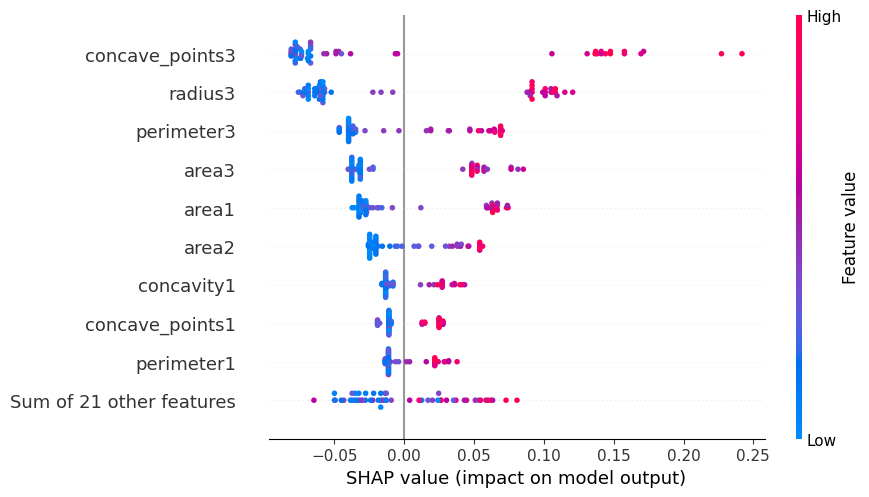

In [132]:
# create an explainer instance from our trained model and test data
explainer = shap.TreeExplainer(rfc, testdf)

# output the Shapely Values from the explainer
shap_values = explainer(testdf)

# generate the explanation of feature importance with column names
tmp = shap.Explanation(shap_values[:, :, 1], data=testdf, feature_names=testdf.columns)

# plot the result
shap.plots.beeswarm(tmp)

## Write Results Back to AzSQL

Now that we have a trained model with predicted results we can write some information back into our Azure SQL Database as a low-level method of experiment tracking.

Here we use the *pyodbc* library to connect to the Azure SQL endpoint and run a SQL Insert statement to insert the algorithm name, accuracy value, and any notes we want to include.

When you run the next cell it will prompt for the Azure SQL Database username/password. You can use your AzureAD credentials for this. 

In [19]:
usr = input("type your username:")
pwd = input("type your password:")
srv = input("type the server name:")
db = input("type the database name:")

server = srv
database = db
username = usr
password = pwd
driver= '{ODBC Driver 17 for SQL Server}'

cnxn = pyodbc.connect('DRIVER='+driver+';PORT=1433;SERVER='+server+';PORT=1443;DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

algorithm = input("Name of Algorithm:")
notes = input("Training Notes:")

cursor.execute("insert into bcwis.algo_details(algorithm,accuracy,notes) values (?, ?, ?)", algorithm,accuracy,notes)
cnxn.commit()
cursor.close()